In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [5]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
resnet_v1_101 = "https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5"

feature_extractor_model = resnet_v1_101

In [6]:
data_root = ("c:/users/HAMZA_MUJTABA/documents/ElectrifyBackend/Images")

In [7]:
batch_size = 32
img_height = 700
img_width = 700

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2876 files belonging to 37 classes.
Using 2301 files for training.
Found 2876 files belonging to 37 classes.
Using 575 files for validation.


In [8]:
class_names = np.array(train_ds.class_names)
print(class_names)

['100R_1-4W' '10R_1W' '10R_2W' '10_1-4W' '11M_1-2W' '150R_1-4W'
 '150R_1-8W' '15R_1-4W' '180K_1-2W' '1K_1-4W' '1K_2W' '1M_1-4W' '20K_1-4W'
 '220K_1-4W' '220R_2W' '22R_1-4W' '24K_1-2W' '270K_1-4W' '27R_1W'
 '2K2_1-4W' '2R_1W' '330R_1-4W' '33K_2W' '3R9K_1-4W' '4700Mohm'
 '470R_1-4W' '470R_1W' '4K7_1-4W' '56K_1W' '5K1_1-4W' '5K61-4W'
 '620R_1-4W' '68K_1W' '6R8_1-4W' '7K5_1-4W' '820R_1-4W' '8K2_1-4W']


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 700, 700, 3)
(32,)


In [12]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(700, 700, 3),
    trainable=False)

In [13]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42605504  
                                                                 
 dense (Dense)               (None, 37)                75813     
                                                                 
Total params: 42,681,317
Trainable params: 75,813
Non-trainable params: 42,605,504
_________________________________________________________________


In [15]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 37])

In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [15]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
72/72 [==============================] - 1139s 16s/step - loss: 2.9188 - acc: 0.2342 - val_loss: 2.2446 - val_acc: 0.4296
Epoch 2/10
72/72 [==============================] - 1090s 15s/step - loss: 1.8737 - acc: 0.5897 - val_loss: 1.6760 - val_acc: 0.6104
Epoch 3/10
72/72 [==============================] - 1103s 15s/step - loss: 1.3813 - acc: 0.7340 - val_loss: 1.3606 - val_acc: 0.7061
Epoch 4/10
72/72 [==============================] - 1103s 15s/step - loss: 1.0861 - acc: 0.8101 - val_loss: 1.1600 - val_acc: 0.7583
Epoch 5/10
72/72 [==============================] - 1054s 15s/step - loss: 0.8884 - acc: 0.8557 - val_loss: 1.0213 - val_acc: 0.7948
Epoch 6/10
72/72 [==============================] - 1097s 15s/step - loss: 0.7464 - acc: 0.8866 - val_loss: 0.9198 - val_acc: 0.8104
Epoch 7/10
72/72 [==============================] - 1088s 15s/step - loss: 0.6393 - acc: 0.9113 - val_loss: 0.8422 - val_acc: 0.8278
Epoch 8/10
72/72 [==============================] - 1073s 15s/step - 

In [ ]:
%tensorboard --logdir logs/fit

In [26]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 12s 12s/step
['270K_1-4W' '270K_1-4W' '270K_1-4W' '270K_1-4W' '270K_1-4W' '6R8_1-4W'
 '270K_1-4W' '270K_1-4W' '220R_2W' '270K_1-4W' '270K_1-4W' '6R8_1-4W'
 '10_1-4W' '270K_1-4W' '470R_1-4W' '270K_1-4W' '270K_1-4W' '270K_1-4W'
 '270K_1-4W' '270K_1-4W' '270K_1-4W' '22R_1-4W' '270K_1-4W' '270K_1-4W'
 '270K_1-4W' '6R8_1-4W' '6R8_1-4W' '270K_1-4W' '270K_1-4W' '470R_1-4W'
 '22R_1-4W' '270K_1-4W']


NameError: name 'predicted_label_batch' is not defined

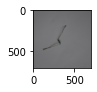

In [25]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [18]:
t = time.time()

export_path = "c:/Users/HAMZA_MUJTABA/Documents/ElectrifyBackend/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: c:/Users/HAMZA_MUJTABA/Documents/ElectrifyBackend/1658467060\assets


INFO:tensorflow:Assets written to: c:/Users/HAMZA_MUJTABA/Documents/ElectrifyBackend/1658467060\assets


'c:/Users/HAMZA_MUJTABA/Documents/ElectrifyBackend/1658467060'

In [17]:
export_path = "c:/Users/HAMZA_MUJTABA/Documents/ElectrifyBackend/1658467060"
reloaded = tf.keras.models.load_model(export_path)
# result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 12s 12s/step


In [20]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [18]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['24K_1-2W' '270K_1-4W' '5K1_1-4W' '100R_1-4W' '4700Mohm' '470R_1-4W'
 '10_1-4W' '820R_1-4W' '470R_1W' '220K_1-4W' '33K_2W' '470R_1-4W' '68K_1W'
 '470R_1-4W' '620R_1-4W' '470R_1-4W' '100R_1-4W' '620R_1-4W' '820R_1-4W'
 '4700Mohm' '5K1_1-4W' '6R8_1-4W' '470R_1-4W' '5K1_1-4W' '330R_1-4W'
 '15R_1-4W' '620R_1-4W' '4700Mohm' '220R_2W' '8K2_1-4W' '4700Mohm' '1K_2W']


<class 'tensorflow.python.framework.ops.EagerTensor'>


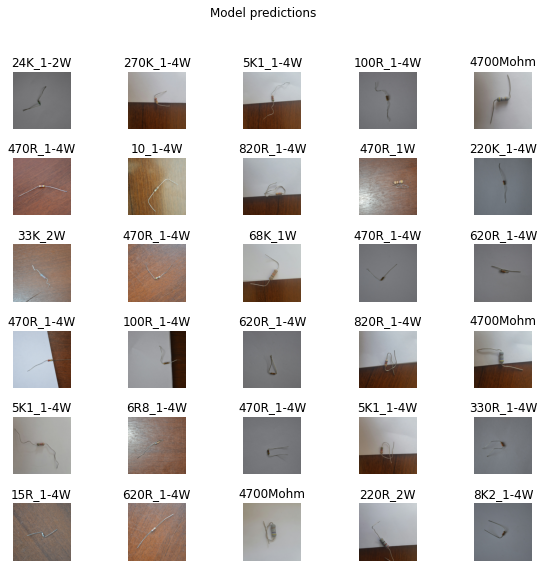

In [28]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  # plt.suptitle(image_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")
plt.savefig('reloaded_results.png')
print(type(labels_batch))

In [24]:
labels_path = ("c:/users/HAMZA_MUJTABA/documents/ElectrifyBackend/names.txt")
imagenet_labels = np.array(open(labels_path).read().splitlines())
print(imagenet_labels)

['100R_1-4W' '10R_1W' '10R_2W' '10_1-4W' '11M_1-2W' '150R_1-4W'
 '150R_1-8W' '15R_1-4W' '180K_1-2W' '1K_1-4W' '1K_2W' '1M_1-4W' '20K_1-4W'
 '220K_1-4W' '220R_2W' '22R_1-4W' '24K_1-2W' '270K_1-4W' '27R_1W'
 '2K2_1-4W' '2R_1W' '330R_1-4W' '33K_2W' '3R9K_1-4W' '4700Mohm'
 '470R_1-4W' '470R_1W' '4K7_1-4W' '56K_1W' '5K1_1-4W' '5K61-4W'
 '620R_1-4W' '68K_1W' '6R8_1-4W' '7K5_1-4W' '820R_1-4W' '8K2_1-4W']
